In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import itertools
import numpy as np
from collections import Counter
from tqdm.notebook import tqdm
from time import time
import PIL
from PIL import Image

In [2]:
device = torch.device("cpu")

In [3]:
root_dir = os.getcwd()
dataset_dir = os.path.join(root_dir, "dataset")

In [4]:
tensor_transform = transforms.Compose([
    transforms.ToTensor()])
    
train_dataset = ImageFolder(os.path.join(dataset_dir, 'train'), tensor_transform)
test_dataset = ImageFolder(os.path.join(dataset_dir, 'test'), tensor_transform)

In [5]:
print(dict(Counter(train_dataset.targets)))
print(f"number of class is : {len(dict(Counter(train_dataset.targets)))}")

{0: 68, 1: 75, 2: 100, 3: 88, 4: 86, 5: 69, 6: 89, 7: 99, 8: 79, 9: 84}
number of class is : 10


In [7]:
N_CHANNELS = 3

full_loader = DataLoader(dataset=train_dataset, shuffle=False, num_workers=os.cpu_count())

before = time()
mean = torch.zeros(3)
std = torch.zeros(3)
print('==> Computing mean and std..')
for inputs, _labels in tqdm(full_loader):
    for i in range(N_CHANNELS):
        mean[i] += inputs[:,i,:,:].mean()
        std[i] += inputs[:,i,:,:].std()
mean.div_(len(train_dataset))
std.div_(len(train_dataset))
print(mean, std)

print("time elapsed: ", time()-before)

==> Computing mean and std..


  0%|          | 0/837 [00:00<?, ?it/s]

/home/zhfall/miniconda3/envs/tf/lib/python3.11/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/zhfall/miniconda3/envs/tf/lib/python3.11/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/zhfall/miniconda3/envs/tf/lib/python3.11/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


tensor([0.6569, 0.5918, 0.4345]) tensor([0.2274, 0.2385, 0.2745])
time elapsed:  53.59950375556946


In [7]:
mean = [0.6840, 0.5786, 0.5037]
std = [0.2586, 0.3219, 0.3662]

tensor_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),
                        torch.Tensor(std)) 
])

train_dataset = ImageFolder(os.path.join(dataset_dir, 'train'), tensor_transform)
test_dataset = ImageFolder(os.path.join(dataset_dir, 'test'), tensor_transform)

In [8]:
#hyperparameters
batch_size = 16

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=1,
                         shuffle=False)

In [37]:
epochs = 10
learning_rate = 0.001

width = 224
height = 224
n_channel = 3

classes = os.listdir(dataset_dir + "/train")

In [40]:
classes = ["apple", "banana", "grapes", "kiwi", "mango", "orange", "pear", "pinapple", "pomegranate", "watermelon"]

In [26]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(n_channel, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32*24*24, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 32*24*24)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)       
        return x

In [27]:
model = ConvNet()

criteration = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)

In [28]:
# train
before = time()
loss_values = []
for epoch in range(epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        
        # forward
        outputs = model(images)
        loss = criteration(outputs, labels)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0) 
        
        if (i + 1) % 20 == 0:
            print(f"epoch {epoch + 1}/{epochs}, step {i+1}/{n_total_steps}, loss {loss.item():.4f}")
    
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1}/{epochs}, step {i+1}/{n_total_steps}, epoch loss {epoch_loss:.4f}")
print("time elapsed: ", time()-before)

epoch 1/10, step 20/53, loss 2.1421
epoch 1/10, step 40/53, loss 1.8360
epoch 1/10, step 53/53, epoch loss 33.8734
epoch 2/10, step 20/53, loss 1.7280
epoch 2/10, step 40/53, loss 1.0990
epoch 2/10, step 53/53, epoch loss 26.7897
epoch 3/10, step 20/53, loss 0.9861
epoch 3/10, step 40/53, loss 1.0987
epoch 3/10, step 53/53, epoch loss 22.3106
epoch 4/10, step 20/53, loss 1.5994
epoch 4/10, step 40/53, loss 0.8149
epoch 4/10, step 53/53, epoch loss 19.5915
epoch 5/10, step 20/53, loss 1.0647
epoch 5/10, step 40/53, loss 1.7568
epoch 5/10, step 53/53, epoch loss 16.4439
epoch 6/10, step 20/53, loss 0.5870
epoch 6/10, step 40/53, loss 0.7646
epoch 6/10, step 53/53, epoch loss 13.3410
epoch 7/10, step 20/53, loss 0.2899
epoch 7/10, step 40/53, loss 0.4579
epoch 7/10, step 53/53, epoch loss 10.2864
epoch 8/10, step 20/53, loss 0.4287
epoch 8/10, step 40/53, loss 0.7284
epoch 8/10, step 53/53, epoch loss 7.4250
epoch 9/10, step 20/53, loss 0.2041
epoch 9/10, step 40/53, loss 0.1215
epoch 9/1

Text(0, 0.5, 'loss')

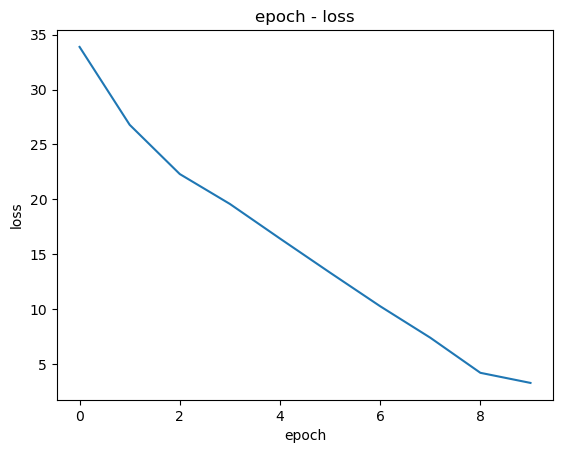

In [29]:
plt.plot(loss_values)
plt.title("epoch - loss")
plt.xlabel("epoch")
plt.ylabel("loss")

In [30]:
# test
conf_matrix = np.zeros(shape=(len(classes),len(classes)))
with torch.no_grad():
    for image, label in tqdm(test_loader):
        output = model(image)
        # value, index
        _, prediction = torch.max(output, 1)
        
        conf_matrix[label][prediction] += 1

  0%|          | 0/99 [00:00<?, ?it/s]

In [31]:
correct = 0
for i in range(len(conf_matrix)):
    correct += conf_matrix[i][i]
    
acc = correct / len(test_loader)
recall = np.mean(np.diag(conf_matrix) / np.sum(conf_matrix, axis = 1))
precision = np.mean(np.diag(conf_matrix) / np.sum(conf_matrix, axis = 0))

In [32]:
print(f"overall accuracy is {acc:.2f}")
print(f"overall precision is {precision:.2f}")
print(f"overall recall is {recall:.2f}")

overall accuracy is 0.95
overall precision is 0.95
overall recall is 0.95


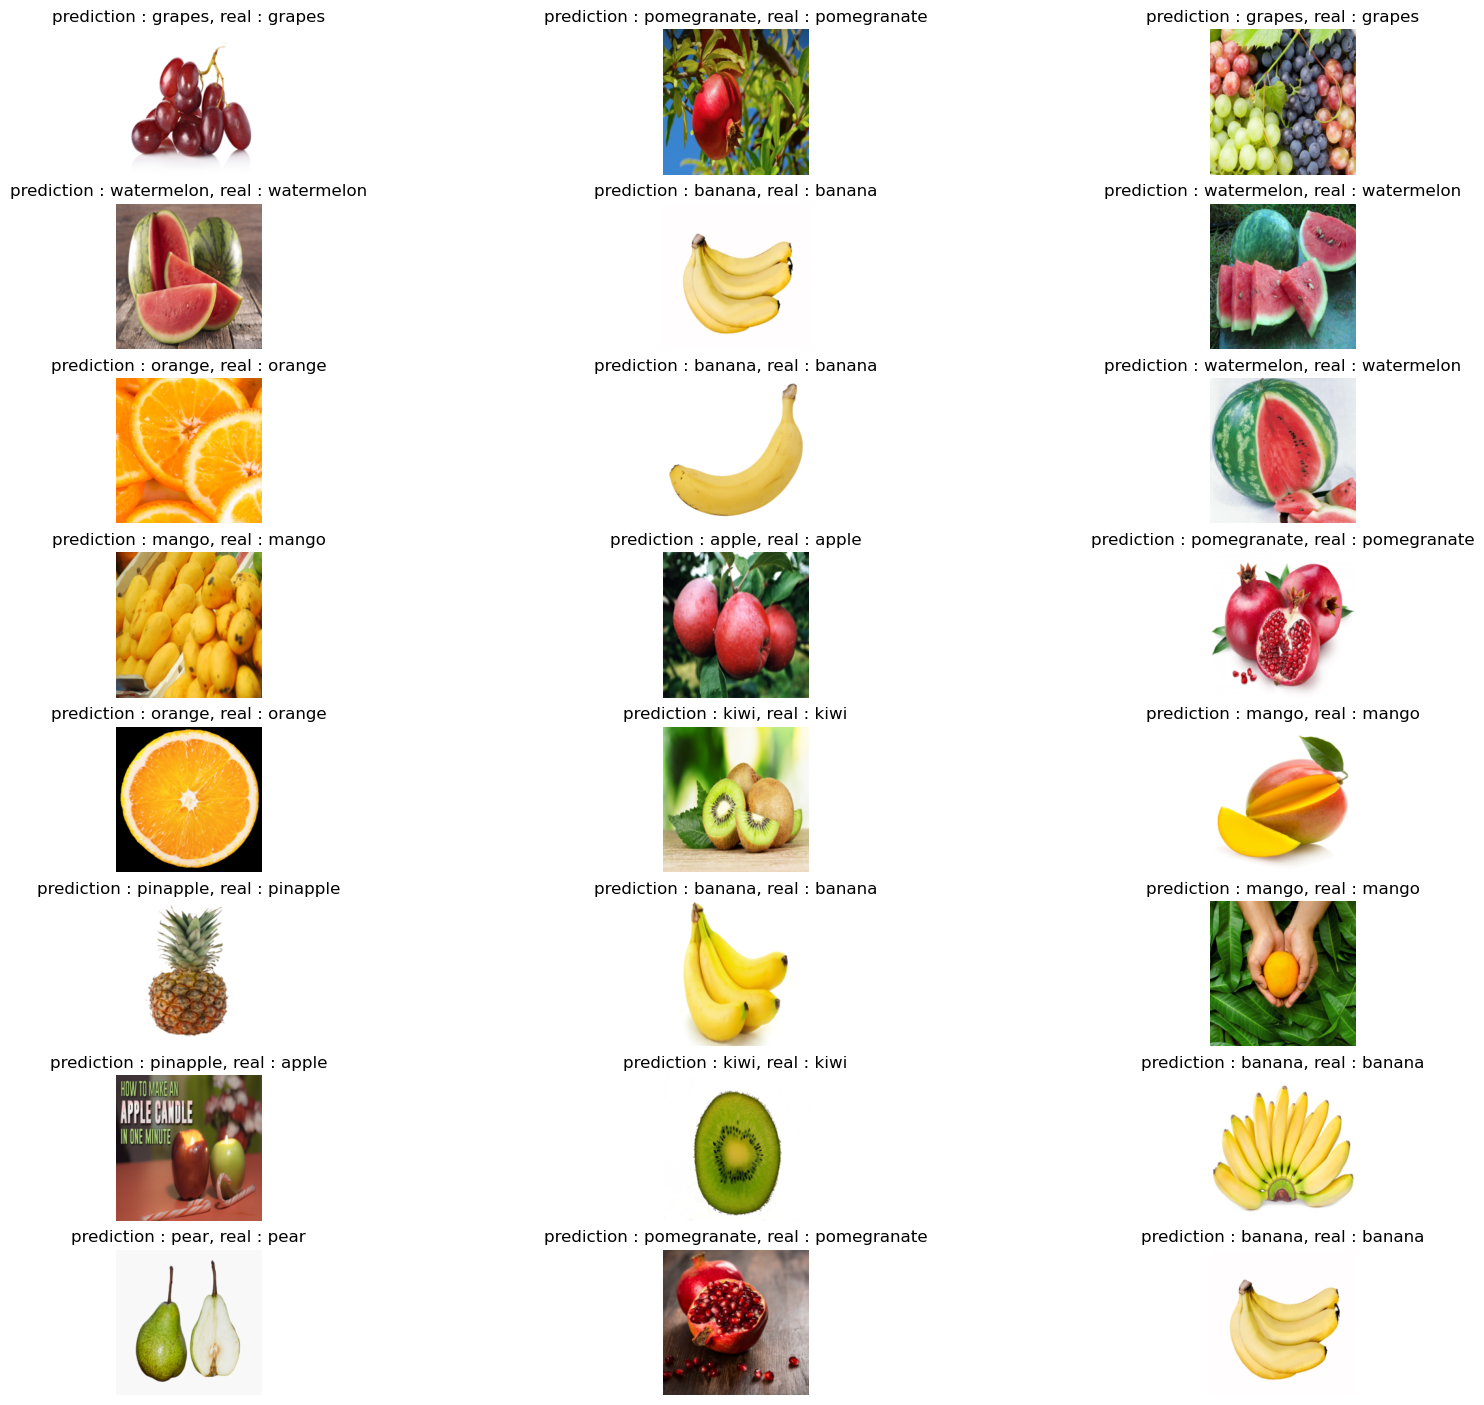

In [45]:
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=1,
                        shuffle=True)

# to unnormalize images, so we can see them better :)
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

plt.figure(figsize=(20,20))
columns = 3
with torch.no_grad():

    for i, (image, label) in enumerate(test_loader):
        if i == 24:
            break
        plotImg = inv_normalize(image[0])
        plt.subplot(int(24 / columns + 1), columns, i + 1)
        plt.imshow((plotImg.permute(1,2,0)))
        plt.axis("off")
        output = model(image)
        _, prediction = torch.max(output, 1)
        plt.title(f"prediction : {classes[prediction]}, real : {classes[label]}")